# Tenicatura Universitaria en Inteligencia Artificial.
## Trabajo Práctico Final: Procesamiento de Lenguaje Natural.
Eugenio Bravi B-6600/1

# Imports

In [1]:
!apt-get update
!pip install selenium webdriver-manager
!pip install langdetect
!pip install gdown
!pip install PyPDF2
!pip install youtube-transcript-api
!pip install rdflib
!pip install chromadb

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,196 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,632 kB]
Get:13 http://security.ubunt

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import re
from langdetect import detect
import gdown
from PyPDF2 import PdfReader
import unicodedata
from youtube_transcript_api import YouTubeTranscriptApi
import networkx as nx
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib.namespace import RDF, RDFS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import chromadb
from langchain.text_splitter import RecursiveCharacterTextSplitter
import uuid

# 1 - Scrapping

### links

viticulture: https://boardgamegeek.com/boardgame/128621/viticulture

reglas: https://cdn.1j1ju.com/medias/9f/c0/a5-viticulture-essential-edition-rulebook.pdf

resumen reglas: https://www.dropbox.com/scl/fo/ulyfze69rb24tsgip7mn7/AHdtHpmeiGhuw3JeMXRcgRY/Viticulture/QuickGuide_EssEd_r3_Prepped.pdf?rlkey=0ejidzd7lktoa5hyrbkmy9xse&e=1&dl=0

Guia del foro: https://boardgamegeek.com/thread/1128733/enders-comprehensive-pictorial-overview-the-new-se

Analisis del foro: https://boardgamegeek.com/thread/1277545/radio-review-69-viticulture

video tutorial: https://www.youtube.com/watch?v=_93EhVaPuXM

video tutorial 2: https://www.youtube.com/watch?v=L5fcDctkFFE&t=22s

gameplay: https://www.youtube.com/watch?v=6svTlK6kP3s


In [3]:
def set_up_driver():
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')

    # Configure driver path
    service = Service('/usr/bin/chromedriver')
    driver = webdriver.Chrome(options=chrome_options)
    return driver

In [4]:
def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()

    # Eliminar caracteres no deseados (excepto letras, números, espacios, puntuación básica)
    texto = re.sub(r'[^a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ\s.,;!?()-]', '', texto)

    # Eliminar los saltos de línea y la barra invertida '\'
    texto = texto.replace('\n', ' ').replace('\\', ' ').replace('-', '')

    # Eliminar múltiples espacios
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

In [5]:
def scrape_board_game_info(url_base, titulos):
    driver = set_up_driver()

    # Diccionario de resultados
    resultados = {}

    try:
        # Recolectar URLs
        urls_personas = []
        urls_editorial = []
        urls_familia = []

        for categoria in ['designer', 'artist', 'publisher', 'family']:
            driver.get(url_base)

            selector = f'a.ng-binding[ng-href*="/boardgame{categoria}/"]'
            enlaces = driver.find_elements(By.CSS_SELECTOR, selector)

            # Extraer URLs
            urls_href = [enlace.get_attribute('href') for enlace in enlaces]
            for url in urls_href:
                if categoria == 'publisher':
                    urls_editorial.append(url)
                elif categoria == 'family':
                    urls_familia.append(url)
                else:
                    urls_personas.append(url)

        # Procesar información para cada título
        for titulo in titulos:
            if titulo in ['designer', 'artist']:
                detalles = []
                for url in urls_personas:
                    driver.get(url)

                    try:
                        # Intentar encontrar el elemento del nombre
                        elemento_nombre = driver.find_element(By.CSS_SELECTOR, f'a.ng-binding[ng-href*="/boardgame{titulo}/"]')
                        nombre_persona = elemento_nombre.text.strip()
                    except:
                        continue

                    # Otros juegos
                    try:
                        boton_ver_todo = WebDriverWait(driver, 3).until(
                            EC.presence_of_element_located((By.XPATH, "//a[contains(text(), 'See All')]"))
                        )
                        enlace_ver_todo = boton_ver_todo.get_attribute("href")
                        driver.get(enlace_ver_todo)

                        WebDriverWait(driver, 3).until(
                            EC.presence_of_all_elements_located((By.XPATH, "//h3[@class='summary-item-title summary-item-title-separated fs-inherit mb-0']/a"))
                        )

                        elementos_juegos = driver.find_elements(By.XPATH, "//h3[@class='summary-item-title summary-item-title-separated fs-inherit mb-0']/a")[:10]
                        otros_juegos = [juego.text.strip() for juego in elementos_juegos]
                    except:
                        otros_juegos = []

                    detalles.append({
                        'Name': nombre_persona,
                        'Other Games': otros_juegos,
                    })

                resultados[titulo] = detalles

            elif titulo == 'publisher':
                detalles = []
                for url in urls_editorial:
                    driver.get(url)
                    detalle = {'Name': driver.find_element(By.CSS_SELECTOR, f'a.ng-binding[ng-href*="/boardgame{titulo}/"]').text.strip()}
                    detalles.append(detalle)
                resultados[titulo] = detalles

            elif titulo == 'related_games':
                detalles = []
                for url in urls_familia:
                    driver.get(url)
                    elemento_tema = driver.find_element(By.CSS_SELECTOR, f'a.ng-binding[ng-href*="/boardgamefamily/"]')
                    tema = elemento_tema.text.strip()

                    if ":" in tema:
                        tematica, nombre = [parte.strip() for parte in tema.split(":", 1)]
                    else:
                        tematica = tema
                        nombre = ""

                    detalles.append({
                        'Subject': tematica,
                        'Name': nombre
                    })

                resultados[titulo] = detalles

            # Nombres alternativos
            if titulo == 'alternative_names':
                try:
                    driver.get(url_base)
                    WebDriverWait(driver, 3).until(
                        EC.presence_of_all_elements_located((By.XPATH, "//div[@ng-switch-when='alternatename']"))
                    )

                    elementos_nombres_alt = driver.find_elements(By.XPATH, "//div[@ng-switch-when='alternatename']")
                    nombres_alt = [elemento.text.strip() for elemento in elementos_nombres_alt if elemento.text.strip()]

                    detalles = []
                    for nombre in nombres_alt:
                        detalles.append({
                            'Alternative Name': nombre,
                            'Language': detect(nombre)
                        })

                    resultados[titulo] = detalles
                except:
                    resultados[titulo] = None

            # Características
            if titulo == 'caracteristics':
                try:
                    driver.get(url_base)
                    WebDriverWait(driver, 3).until(
                        EC.presence_of_all_elements_located((By.XPATH, "//a[@class='ng-binding']"))
                    )

                    # Encontrar elementos de categoría
                    elementos_categorias = driver.find_elements(By.CSS_SELECTOR, 'a.ng-binding[ng-href*="/boardgamecategory/"]')
                    categorias = [elemento.text.strip() for elemento in elementos_categorias if elemento.text.strip()]

                    # Encontrar elementos de mecánica
                    elementos_mecanicas = driver.find_elements(By.CSS_SELECTOR, 'a.ng-binding[ng-href*="/boardgamemechanic/"]')
                    mecanicas = [elemento.text.strip() for elemento in elementos_mecanicas if elemento.text.strip()]

                    detalles = [{
                        'categories': categorias,
                        'mechanics': mecanicas,
                        'year_release': '2013'
                    }]

                    resultados[titulo] = detalles
                except:
                    resultados[titulo] = None

            # Premios del juego
            elif titulo == 'award_game':
                try:
                    driver.get('https://boardgamegeek.com/boardgame/128621/viticulture')
                    WebDriverWait(driver, 3).until(
                        EC.presence_of_all_elements_located((By.XPATH, "//a[@class='ng-binding']"))
                    )

                    elementos_premios = driver.find_elements(By.XPATH, "//a[@class='ng-binding'][contains(@ng-href, '/boardgamehonor/')]")

                    detalles = []
                    for premio in elementos_premios:
                        texto = premio.text.strip()
                        coincidencia = re.match(r"(\d{4})\s*(.*)", texto)

                        if coincidencia:
                            año = coincidencia.group(1)
                            nombre = coincidencia.group(2).strip()
                            detalles.append({
                                'Prize': nombre,
                                'Year': año
                            })

                    resultados[titulo] = detalles
                except:
                    resultados[titulo] = None

    finally:
        driver.quit()

    return resultados



In [6]:
# Example usage
url_credits = "https://boardgamegeek.com/boardgame/128621/viticulture/credits"
titles_to_scrape = ['designer', 'artist', 'publisher', 'related_games', 'alternative_names', 'award_game','caracteristics']

viticulture_info = scrape_board_game_info(url_credits, titles_to_scrape)

In [7]:
viticulture_info

{'designer': [{'Name': 'Jamey Stegmaier',
   'Other Games': ['Charterstone (2017)',
    'Charterstone: Recharge Pack (2017)',
    'Euphoria: Build a Better Dystopia (2013)',
    'Euphoria: Participate In The Game or Watch It Played (2015)',
    'Expeditions (2023)',
    'Expeditions: Gears of Corruption (2024)',
    'Red Rising (2021)',
    'Rolling Realms (2021)',
    'Rolling Realms Redux (2024)',
    'Rolling Realms: Ark Nova Promo Pack (2022)']},
  {'Name': 'Alan Stone',
   'Other Games': ['Euphoria: Build a Better Dystopia (2013)',
    'Euphoria: Participate In The Game or Watch It Played (2015)',
    'Viticulture (2013)',
    'Viticulture Essential Edition (2015)',
    'Viticulture: Arboriculture and Formaggio Expansions (2013)',
    "Viticulture: Complete Collector's Edition (2014)",
    'Viticulture: Kickstarter Promotional Cards (2013)',
    'Viticulture: Moor Visitors Expansion (2016)',
    'Viticulture: Tuscany (2014)',
    'Viticulture: Tuscany Essential Edition (2016)']}],

### Descargamos las reglas y el resumen de las reglas

In [8]:
def extract_clean_pdf_text(pdf_path):
    # Abrir y leer el PDF
    with open(pdf_path, "rb") as pdf_file:
        reader = PdfReader(pdf_file)

        # Extraer y limpiar el texto de todas las páginas
        full_text = ""
        for page in reader.pages:
            # Extraer el texto de la página
            page_text = page.extract_text()

            # Limpiar el texto
            page_text = re.sub(r'\\u[0-9a-fA-F]{4}|\\x[0-9a-fA-F]{2}', '', page_text)
            page_text = re.sub(r'[^a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ\s.,;!?()-]', '', page_text)
            page_text = re.sub(r'\s+', ' ', page_text).strip()

            # Convertir a minúsculas
            page_text = page_text.lower().replace("\n", " ")

            # Eliminar espacios antes de signos de puntuación
            page_text = re.sub(r'\s([?.!,;:](?:\s|$))', r'\1', page_text)

            # Reemplazar comillas y guiones especiales
            page_text = page_text.replace('“', '"').replace('”', '"')
            page_text = page_text.replace('‘', "'").replace('’', "'")
            page_text = page_text.replace('–', '-')

            # Normalizar caracteres (eliminar acentos)
            page_text = unicodedata.normalize('NFKD', page_text).encode('ASCII', 'ignore').decode('utf-8')

            # Agregar al texto completo si no está vacío
            if page_text:
                full_text += page_text + " "

        # Eliminar espacios adicionales
        return full_text.strip()

In [9]:
# Descargar primer archivo
gdown.download('https://drive.google.com/uc?id=17yeyWvdLULFWS4R6lGTkYwqmNmaX95t_', "reglas.pdf", quiet=False)

# Descargar segundo archivo
gdown.download('https://drive.google.com/uc?id=1HqADbc_9grBqkrd6l_2GuXeOT3kxRe2g', "reglas_resumen.pdf", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=17yeyWvdLULFWS4R6lGTkYwqmNmaX95t_
To: /content/reglas.pdf
100%|██████████| 10.9M/10.9M [00:00<00:00, 36.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HqADbc_9grBqkrd6l_2GuXeOT3kxRe2g
To: /content/reglas_resumen.pdf
100%|██████████| 3.23M/3.23M [00:00<00:00, 19.9MB/s]


'reglas_resumen.pdf'

In [10]:
reglas = extract_clean_pdf_text("./reglas.pdf")
reglas_resumen = extract_clean_pdf_text("./reglas_resumen.pdf")
reglas

'stonemaier games presents designed by jamey stegmaier, alan stone, morten monrad pedersen illustrated by beth sobelessential edition old-world tuscany awaits your winemaking skill and strategic cunning. youll plant vines, harvest grapes, age wines, and fill merchant orders to create the greatest winery in italy! object of the game players allocate workers and play visitors to complete various tasks throughout the seasons (each worker is placed on one action each year). in the spring, players decide the schedule their workers will follow. an early rise gives the player the chance to act first; however, offering workers a later wake-up time gives you more valuable bonuses. in the summer, players place workers on action spaces to plant vines and build structures that help advance that players vineyard. in the fall, players invite visitors to help their workers. in the winter, players place workers on action spaces to harvest grapes, make wine, and fill orders.goal the goal is to reach 20

In [11]:
reglas_resumen

't urn summary completely proceed through each season in order, starting with spring. in summer and winter, in turn (wake-up) order, each player may take a turn to place one worker on one action space in the current season. players may only take actions they are capable of completing. that worker cannot be moved again until the end of the year. a player may pass but then cannot take any more actions that season; move the players rooster (to the right in summer, left in winter) to signify this. repeat in turn order until all players have passed. then proceed to the next season. action spaces when playing a 2-player game, use only the action space on the left. with 3 4, add the middle space ( bonus space ). with 5 6, use all three. available spaces may be used in any order. using bonus spaces you may take the bonus before or after the main action (or not at all). friendly variant you may use the bonus space only if you can complete the bonus action unless the actions other spaces are alr

## Scrape tutoriales del foro

In [12]:
def scrap_game_tutorial(url):
    """
    Extrae el contenido de texto de un tutorial de juego desde una URL específica.

    Parámetros:
    url (str): La URL del tutorial del juego a extraer.

    Retorna:
    str: Texto limpio extraído de los elementos con selector CSS 'gg-markup-safe-html',
         o un texto vacío si ocurre un error.
    """
    driver = set_up_driver()

    try:
        # Navegar a la página
        driver.get(url)

        # Esperar y encontrar elementos con el selector CSS especificado
        elementos = WebDriverWait(driver, 3).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'gg-markup-safe-html'))
        )

        # Extraer texto de los elementos, eliminando espacios en blanco
        textos = [elemento.text.strip() for elemento in elementos if elemento.text.strip()]

        # Unir los textos y limpiarlos
        texto_final = " ".join(textos)
        return limpiar_texto(texto_final)

    except Exception as e:
        print(f"Ocurrió un error: {e}")
        return ""

    finally:
        # Cerrar siempre el driver para liberar recursos
        driver.quit()


In [13]:
game_tutorial = scrap_game_tutorial('https://boardgamegeek.com/thread/1128733/enders-comprehensive-pictorial-overview-the-new-se')
game_tutorial

'introducing viticulture one of the big kickstarter successes from 2013 was , by jamey stegmaier and alan stone. this worker placement game for 26 players is themed around growing grapes and producing wine, an art thats more glamorously known as viticulture. the game plays in around 6090 minutes, and has proved to be very popular. its kickstarter project was also a big success, being widely considered as one of the most outstandingly run kickstarters for a board game in recent memory. while viticulture is an excellent euro game in its own right, and was generally very well received and lauded for its components and gameplay, it is no real surprise that the first edition has paved the way for a second edition and expansions. the original game did have a few small wrinkles that needed to be improved (e.g. by the addition of grande workers, which give players more flexibility in worker placement). at the same time the first edition of viticulture was certainly good enough to make enthusia

In [14]:
game_analisis = scrap_game_tutorial('https://boardgamegeek.com/thread/1277545/radio-review-69-viticulture')
game_analisis

'viticulture (2013 stonemaier games) a bottle of white, a bottle of red....maybe a bottle of rose instead.... its fair to say designers jamey stegmaier and alan stone had a pretty good 2013. their two successful kickstarter campaigns (for viticulture and euphoria) initiated their companys emergence as a small publisher recognized for their design of eurostyle worker placement games. both games were highly regarded within the board game community upon release, and in fact both have done so well, theyve already seen second editions. earlier this year i took a look at euphoria and was vastly impressed with how well the game was able to merge its theme and mechanics together. a sort of symbiotic relationship that fueled what i think to be one of the most unique worker placement games on the market. since then, viticulture has been one that ive been interested in trying, and was finally able to pick up when the second edition released this past month. in viticulture (second edition), player

### Scrape transcripto de videos

In [15]:
def get_youtube_transcript(video_url, idioma):
    """
    Obtiene y procesa la transcripción de un video de YouTube.
    Parámetros:
    video_url (str): URL completa del video de YouTube
    idioma (str): Código de idioma de la transcripción deseada
    Retorna:
    str: Transcripción completa del video, o None si ocurre un error
    """
    try:
        # Extraer ID del video usando expresión regular
        video_id = re.findall(r'(?:v=|\/)([0-9A-Za-z_-]{11}).*', video_url)[0]

        # Obtener la transcripción en el idioma especificado
        transcript_list = YouTubeTranscriptApi.get_transcript(video_id, languages=(idioma,))

        # Combinar entradas de la transcripción
        return ' '.join(entrada['text'] for entrada in transcript_list)

    except Exception as e:
        print(f"Error al obtener la transcripción: {e}")
        return None


In [16]:
video_url = 'https://www.youtube.com/watch?v=_93EhVaPuXM'
como_jugar = get_youtube_transcript(video_url,'en')
como_jugar = limpiar_texto(como_jugar)
como_jugar

'hi my name is evinya this is peter welcome to games made easy a channel to learn board games quickly and easily today im really happy to teach you and give you tips on how to play viticulture essential edition what i love in viticulture is how different it is from any other game ive played it has a completely different rhythm and the more you play it the faster it gets its also really pretty if youre new to the channel dont forget to subscribe in viticulture two to six players have just inherited a vineyard in tuscany and they compete to build their wine business you score points by planting vines by harvesting grapes making wine and selling that wine you start with only a handful of workers a basic winery and you can receive help from seasonal visitors your goal is to build up your reputation as soon as one player reaches 20 points finish the year and the player with the most points wins the game now lets look at the components in more detail while we set up the game like many stonem

In [17]:
video_url_2 = 'https://www.youtube.com/watch?v=L5fcDctkFFE&t=22s'
guia_consejos = get_youtube_transcript(video_url_2,'en')
guia_consejos = limpiar_texto(guia_consejos)
guia_consejos

'(music) in this video were going to learn the 26 player game, viticulture, by stonemaier games. now sure people enjoy wine, but they should be enjoying wine from your cellars but youre going to need to carefully crush and properly harvest the grapes from the rich vines of your many fields and assign your workers to the right task and invest your earnings wisely if you wish to serve the finest wines in old world tuscany. so join me at the table and lets learn how to play. first you lay out the game board. now this game board actually has two sides. this side has several visual aides to guide you during the gameplay but for more experienced players you may choose to play on this side as theres less text to obscure the artwork. for gameplay purposes theyre both identical, so choose whichever side you want but certainly when youre first learning the game as we are, this side is more helpful. players will now select the color and collect the matching pieces and player board. now like the g

In [18]:
video_url_3 = 'https://www.youtube.com/watch?v=6svTlK6kP3s'
gameplay = get_youtube_transcript(video_url_3,'en')
gameplay = limpiar_texto(gameplay)
gameplay

'whats up everybody my name is nick im mike we other brothers murf and welcome to the game music house tonight im the game house weve got ourselves some atic ch indeed so a couple weeks ago we played your favorite game were playing my favorite game the greatest game ever made vulture its good to play the greats you know were out here playing the greats this is all about making wine getting lit up on your own supply giving tours embarrassing yourself dont drink i do i like vineyards i think theyre really pretty theyre amazing they just inc just give me all the cheese and meats part and some like just weles grape cheese good so before we play this game lets go down the table show you a little bit of an overview of viticulture viticulture is a worker placement game where you will be running your own vineyard harvesting grapes and filling wine orders the game will take place over multiple rounds called years and each year you will do actions in spring summer autumn and winter note that we 

### Scrapeamos stadisticas

In [19]:
def obtener_estadisticas_y_valores(url):
    """
    Extrae estadísticas de un juego desde una página web utilizando Selenium WebDriver.

    Parámetros:
    url (str): URL de la página del juego a scrapear

    Retorna:
    list: Lista de tuplas con las estadísticas y sus valores
    """
    driver = set_up_driver()

    try:
        driver.get(url)
        items = WebDriverWait(driver, 3).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'li.outline-item'))
        )

        resultados = []
        for item in items:
            try:
                stat = item.find_element(By.CSS_SELECTOR, 'div.outline-item-title').text.strip()
                valor = item.find_element(By.CSS_SELECTOR, 'div.outline-item-description a').text.strip()

                resultados.append((stat, valor))
            except Exception:
                continue

        return resultados

    except Exception as e:
        print(f"Error scraping page: {e}")
        return []

    finally:
        driver.quit()

In [20]:
stats = obtener_estadisticas_y_valores('https://boardgamegeek.com/boardgame/128621/viticulture/stats')
stats

[('Avg. Rating', '7.486'),
 ('No. of Ratings', '14,373'),
 ('Weight', '2.94 / 5'),
 ('Comments', '1,921'),
 ('Fans', '896'),
 ('Overall Rank', '291'),
 ('Strategy Rank', '218'),
 ('All Time Plays', '40,984'),
 ('This Month', '172'),
 ('Own', '12,062'),
 ('Prev. Owned', '1,381'),
 ('For Trade', '96'),
 ('Want In Trade', '475'),
 ('Wishlist', '3,882'),
 ('Has Parts', '7'),
 ('Want Parts', '2')]

In [21]:
# varibles con info

# viticulture_info
# reglas
# reglas_resumen
# game_tutorial
# game_analisis
# como_jugar
# guia_consejos
# gameplay
# stats

# Base de datos de grafos

In [22]:
viticulture_info

{'designer': [{'Name': 'Jamey Stegmaier',
   'Other Games': ['Charterstone (2017)',
    'Charterstone: Recharge Pack (2017)',
    'Euphoria: Build a Better Dystopia (2013)',
    'Euphoria: Participate In The Game or Watch It Played (2015)',
    'Expeditions (2023)',
    'Expeditions: Gears of Corruption (2024)',
    'Red Rising (2021)',
    'Rolling Realms (2021)',
    'Rolling Realms Redux (2024)',
    'Rolling Realms: Ark Nova Promo Pack (2022)']},
  {'Name': 'Alan Stone',
   'Other Games': ['Euphoria: Build a Better Dystopia (2013)',
    'Euphoria: Participate In The Game or Watch It Played (2015)',
    'Viticulture (2013)',
    'Viticulture Essential Edition (2015)',
    'Viticulture: Arboriculture and Formaggio Expansions (2013)',
    "Viticulture: Complete Collector's Edition (2014)",
    'Viticulture: Kickstarter Promotional Cards (2013)',
    'Viticulture: Moor Visitors Expansion (2016)',
    'Viticulture: Tuscany (2014)',
    'Viticulture: Tuscany Essential Edition (2016)']}],

In [23]:
designers = viticulture_info['designer']
artists = viticulture_info['artist']
publishers = viticulture_info['publisher']
related_games = viticulture_info['related_games']
alternative_names = viticulture_info['alternative_names']
awards = viticulture_info['award_game']
categories = viticulture_info['caracteristics'][0]['categories']
mechanics = viticulture_info['caracteristics'][0]['mechanics']
year_release = viticulture_info['caracteristics'][0]['year_release']

In [24]:
year_release


'2013'

In [25]:
def create_game_network(game_node, designers, artists, publishers, related_games,
                        alternative_names, awards, categories, mechanics, year_release):
    """
    Construye un grafo de red para un juego de mesa con múltiples relaciones.

    Parámetros:
    - game_node: Nombre del juego principal
    - designers: Lista de diseñadores del juego
    - artists: Lista de artistas del juego
    - publishers: Lista de publicadores
    - related_games: Lista de las relaciones del juego
    - alternative_names: Lista de nombres alternativos
    - awards: Lista de premios
    - categories: Lista de categorías
    - mechanics: Lista de mecánicas
    - year_release: Año de lanzamiento

    Retorna:
    - Grafo de red (networkx DiGraph)
    """
    G = nx.DiGraph()
    G.add_node(game_node, type="game")

    # Función auxiliar para agregar premios a un nodo
    def add_awards_for_node(node):
        for award in awards:
            if award['Prize'] in node:
                award_node = f"{award['Year']} - {award['Prize']}"
                G.add_node(award_node, type="award", year=award['Year'])
                G.add_edge(node, award_node, relationship="awarded or nominated")

    # Procesamiento de diseñadores
    def process_designers():
        for designer in designers:
            G.add_node(designer['Name'], type="designer")
            G.add_edge(game_node, designer['Name'], relationship="designed by")

            for other_game in designer['Other Games']:
                G.add_node(other_game, type="game")
                G.add_edge(designer['Name'], other_game, relationship="designed")
                add_awards_for_node(other_game)

    # Procesamiento de artistas
    def process_artists():
        for artist in artists:
            G.add_node(artist['Name'], type="artist")
            G.add_edge(game_node, artist['Name'], relationship="art by")

            for other_game in artist['Other Games']:
                G.add_node(other_game, type="game")
                G.add_edge(artist['Name'], other_game, relationship="artist of")
                add_awards_for_node(other_game)

    # Procesamiento de publicadores
    def process_publishers():
        for publisher in publishers:
            G.add_node(publisher['Name'], type="publisher")
            G.add_edge(game_node, publisher['Name'], relationship="published by")

    # Procesamiento de las relaciones del juego
    def process_related_games():
        for relation in related_games:
            G.add_node(relation['Name'], type="relation")
            G.add_edge(game_node, relation['Name'], relationship=relation['Subject'])

    # Procesamiento de país
    def process_country():
        country = next((item for item in related_games if item['Subject'] == 'Country'), None)
        if country:
            G.add_node(country['Name'], type="country")
            G.add_edge(game_node, country['Name'], relationship="set in")

    # Procesamiento de nombres alternativos
    def process_alternative_names():
        for alt_name in alternative_names:
            G.add_node(alt_name['Alternative Name'], type="alternative name",
                       language=alt_name['Language'])
            G.add_edge(game_node, alt_name['Alternative Name'],
                       relationship="also known as")

    # Procesamiento de premios
    def process_awards():
        for award in awards:
            award_node = f"{award['Year']} - {award['Prize']}"
            G.add_node(award_node, type="award", year=award['Year'])
            G.add_edge(game_node, award_node, relationship="awarded or nominated")

    # Procesamiento de categorías y mecánicas
    def process_categories_and_mechanics():
        for category in categories:
            G.add_node(category, type="category")
            G.add_edge(game_node, category, relationship="category")

        for mechanic in mechanics:
            G.add_node(mechanic, type="mechanic")
            G.add_edge(game_node, mechanic, relationship="mechanic")

    # Procesamiento del año de lanzamiento
    def process_release_year():
        G.add_node(year_release, type='year')
        G.add_edge(game_node, year_release, relationship="Release year")

    # Ejecutar todos los procesamientos
    process_designers()
    process_artists()
    process_publishers()
    process_related_games()
    process_country()
    process_alternative_names()
    process_awards()
    process_categories_and_mechanics()
    process_release_year()

    return G, game_node

G, game_node = create_game_network(
    game_node="Viticulture",
    designers=designers,
    artists=artists,
    publishers=publishers,
    related_games=related_games,
    alternative_names=alternative_names,
    awards=awards,
    categories=categories,
    mechanics=mechanics,
    year_release=year_release
)

### Graficamos

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12527 (\N{KATAKANA LETTER WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12490 (\N{KATAKANA LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/

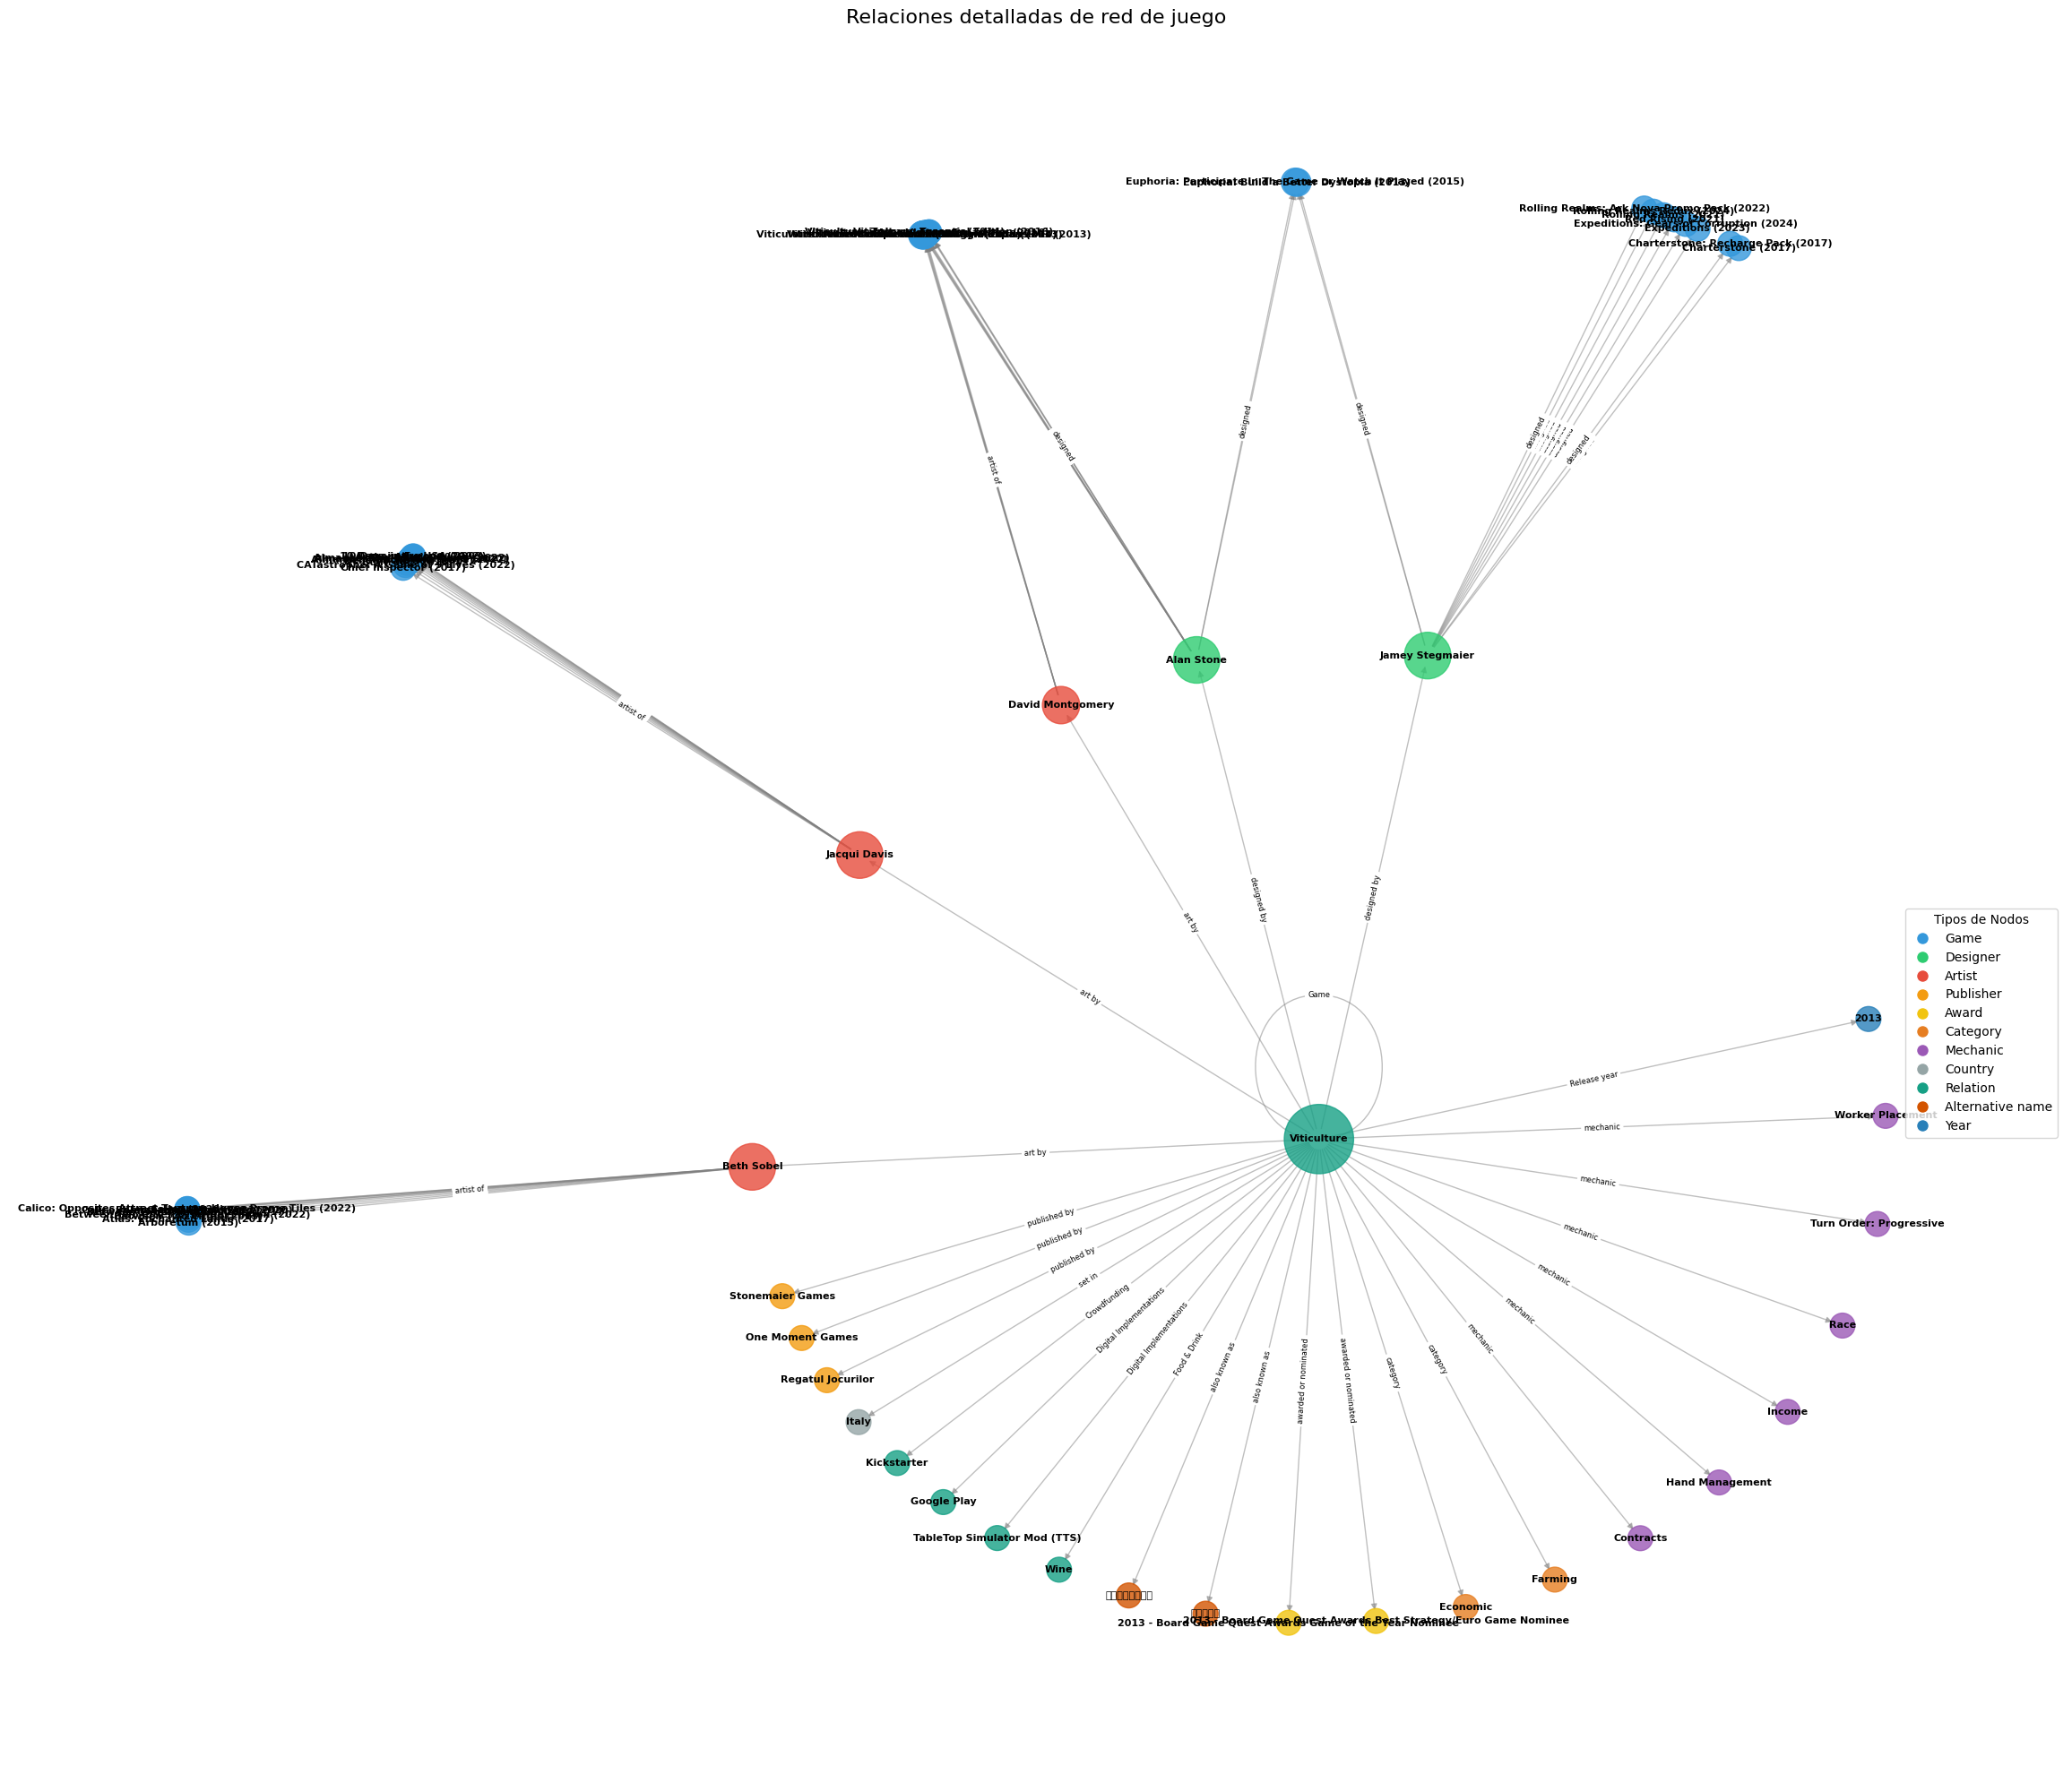

In [26]:
def plot_structured_network_graph(G):
    """
    Genera una visualización estructurada de un grafo de red.

    Parámetros:
    G (networkx.DiGraph): Grafo a visualizar
    """
    # Configuración de colores para tipos de nodos
    COLOR_MAP = {
        'game': '#3498db',      # Azul brillante
        'designer': '#2ecc71',   # Verde
        'artist': '#e74c3c',     # Rojo
        'publisher': '#f39c12',  # Naranja
        'award': '#f1c40f',      # Amarillo
        'category': '#e67e22',   # Naranja oscuro
        'mechanic': '#9b59b6',   # Púrpura
        'country': '#95a5a6',    # Gris
        'relation': '#16a085',   # Verde azulado
        'alternative name': '#d35400',  # Naranja oscuro
        'year': '#2980b9'        # Azul profundo
    }
    DEFAULT_COLOR = 'gray'

    # Configuración de la visualización
    plt.figure(figsize=(25, 20))

    # Calcular disposición de nodos
    pos = nx.kamada_kawai_layout(G)

    # Preparar colores y tamaños de nodos
    def get_node_color(node):
        return COLOR_MAP.get(G.nodes[node].get('type', ''), DEFAULT_COLOR)

    def get_node_size(node):
        return 300 + 100 * G.degree(node)

    node_colors = [get_node_color(node) for node in G.nodes()]
    node_sizes = [get_node_size(node) for node in G.nodes()]

    # Dibujar nodos
    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=node_sizes,
        alpha=0.8
    )

    # Dibujar aristas
    nx.draw_networkx_edges(
        G, pos,
        edge_color='gray',
        arrows=True,
        arrowsize=10,
        alpha=0.5
    )

    # Etiquetas de aristas
    edge_labels = nx.get_edge_attributes(G, 'relationship')
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=6,
        font_color='black'
    )

    # Etiquetas de nodos
    nx.draw_networkx_labels(
        G, pos,
        font_size=8,
        font_weight='bold'
    )

    # Configuración final
    plt.title('Relaciones detalladas de red de juego', fontsize=16)
    plt.axis('off')

    # Crear leyenda
    legend_elements = [
        plt.Line2D([0], [0],
                   marker='o',
                   color='w',
                   label=node_type.capitalize(),
                   markerfacecolor=color,
                   markersize=10)
        for node_type, color in COLOR_MAP.items()
    ]
    plt.legend(
        handles=legend_elements,
        title='Tipos de Nodos',
        loc='best',
        bbox_to_anchor=(1, 0.5)
    )

    plt.tight_layout()
    plt.show()

# Llamada para graficar
plot_structured_network_graph(G)

### Creamos un grafo RDF

In [27]:
def create_rdf_graph(game_node, designers, artists, publishers, related_games,
                     alternative_names, awards, categories, mechanics, year_release):
    """
    Convierte un grafo de red de juegos a un grafo RDF.

    Parámetros:
    - game_node: Nombre del juego principal
    - designers: Lista de diseñadores
    - artists: Lista de artistas
    - publishers: Lista de publicadores
    - related_games: Lista de juegos relacionados
    - alternative_names: Lista de nombres alternativos
    - awards: Lista de premios
    - categories: Lista de categorías
    - mechanics: Lista de mecánicas
    - year_release: Año de lanzamiento

    Retorna:
    - Grafo RDF
    """
    # Crear grafo y namespace
    rdf_graph = Graph()
    GAME = Namespace("http://viticulture.org/game/")

    def sanitize_uri(name):
        """Convierte nombres a URIs válidas"""
        return name.replace(' ', '_').replace('/', '_')

    def add_node_to_rdf(node, node_type):
        """Añade un nodo al grafo RDF"""
        node_uri = URIRef(GAME[sanitize_uri(node)])
        rdf_graph.add((node_uri, RDF.type, GAME[node_type]))
        return node_uri

    def add_edge_to_rdf(subject_uri, predicate, object_uri):
        """Añade una arista al grafo RDF"""
        rdf_graph.add((subject_uri, GAME[predicate], object_uri))

    # Nodo principal del juego
    game_uri = add_node_to_rdf(game_node, 'Game')

    # Procesar diseñadores
    def process_designers():
        for designer in designers:
            designer_uri = add_node_to_rdf(designer['Name'], 'Designer')
            add_edge_to_rdf(game_uri, 'designedBy', designer_uri)

            # Otros juegos del diseñador
            for other_game in designer['Other Games']:
                other_game_uri = add_node_to_rdf(other_game, 'Game')
                add_edge_to_rdf(designer_uri, 'designed', other_game_uri)

    # Procesar artistas
    def process_artists():
        for artist in artists:
            artist_uri = add_node_to_rdf(artist['Name'], 'Artist')
            add_edge_to_rdf(game_uri, 'artBy', artist_uri)

            # Otros juegos del artista
            for other_game in artist['Other Games']:
                other_game_uri = add_node_to_rdf(other_game, 'Game')
                add_edge_to_rdf(artist_uri, 'artistOf', other_game_uri)

    # Procesar publicadores
    def process_publishers():
        for publisher in publishers:
            publisher_uri = add_node_to_rdf(publisher['Name'], 'Publisher')
            add_edge_to_rdf(game_uri, 'publishedBy', publisher_uri)

    # Procesar premios
    def process_awards():
        for award in awards:
            award_uri = add_node_to_rdf(f"{award['Year']} - {award['Prize']}", 'Award')
            add_edge_to_rdf(game_uri, 'awardedOrNominated', award_uri)

    # Procesar categorías y mecánicas
    def process_categories_and_mechanics():
        for category in categories:
            category_uri = add_node_to_rdf(category, 'Category')
            add_edge_to_rdf(game_uri, 'hasCategory', category_uri)

        for mechanic in mechanics:
            mechanic_uri = add_node_to_rdf(mechanic, 'Mechanic')
            add_edge_to_rdf(game_uri, 'hasMechanic', mechanic_uri)

    # Procesar juegos relacionados
    def process_related_games():
        for relation in related_games:
            related_game_uri = add_node_to_rdf(relation['Name'], 'RelatedGame')
            add_edge_to_rdf(game_uri, 'relatedTo', related_game_uri)

    # Procesar nombres alternativos
    def process_alternative_names():
        for alt_name in alternative_names:
            alt_name_uri = add_node_to_rdf(alt_name['Alternative Name'], 'AlternativeName')
            add_edge_to_rdf(game_uri, 'alsoKnownAs', alt_name_uri)

    # Procesar año de lanzamiento
    def process_release_year():
        year_uri = add_node_to_rdf(str(year_release), 'Year')
        add_edge_to_rdf(game_uri, 'releaseYear', year_uri)

    # Ejecutar todos los procesamientos
    process_designers()
    process_artists()
    process_publishers()
    process_awards()
    process_categories_and_mechanics()
    process_related_games()
    process_alternative_names()
    process_release_year()

    return rdf_graph

rdf_graph = create_rdf_graph(
    game_node="Viticulture",
    designers=designers,
    artists=artists,
    publishers=publishers,
    related_games=related_games,
    alternative_names=alternative_names,
    awards=awards,
    categories=categories,
    mechanics=mechanics,
    year_release=year_release
)

In [28]:
sparql_query = """
PREFIX game: <http://viticulture.org/game/>

SELECT ?designerName ?gameName
WHERE {
    ?game game:designedBy ?designer .
    BIND(STRAFTER(STR(?designer), '/game/') AS ?designerName)
    BIND(STRAFTER(STR(?game), '/game/') AS ?gameName)
}
"""

# Execute the query
results = rdf_graph.query(sparql_query)

# Process results to get clean string names
processed_results = [(str(row.designerName), str(row.gameName)) for row in results]

for result in processed_results:
    print(result)

('Jamey_Stegmaier', 'Viticulture')
('Alan_Stone', 'Viticulture')


# Base de datos tabular

# Base de datos vectorial

In [29]:
def get_chunks(text: str) -> list[str]:
  """
  Dado un texto, devuelve una lista de chunks.
  Args:
    text: texto a dividir.

  Returns:
    Lista de chunks.
  """
  splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=30)
  chunks = splitter.split_text(text)
  return chunks

In [30]:
chunks_reglas = get_chunks(reglas)
chunks_reglas_resumen = get_chunks(reglas_resumen)
chunks_game_tutorial = get_chunks(game_tutorial)
chunks_game_analisis = get_chunks(game_analisis)
chunks_como_jugar = get_chunks(como_jugar)
chunks_guia_consejos = get_chunks(guia_consejos)
chunks_gameplay = get_chunks(gameplay)

In [31]:
chunks_gameplay

['whats up everybody my name is nick im mike we other brothers murf and welcome to the game music house tonight im the game house weve got ourselves some atic ch indeed so a couple weeks ago we played your favorite game were playing my favorite game the greatest game ever made vulture its good to play the greats you know were out here playing the greats this is all about making wine getting lit up on your own supply giving tours embarrassing yourself dont drink i do i like vineyards i think theyre',
 'like vineyards i think theyre really pretty theyre amazing they just inc just give me all the cheese and meats part and some like just weles grape cheese good so before we play this game lets go down the table show you a little bit of an overview of viticulture viticulture is a worker placement game where you will be running your own vineyard harvesting grapes and filling wine orders the game will take place over multiple rounds called years and each year you will do actions in spring sum